# Pulsebuilding tutorial

## Table of Contents

 * [Lingo](#Lingo)
 * [Blueprints](#Blueprints)
   * [Basic blueprinting](#Basic-blueprinting)
   * [Markers](#Markers)
   * [Modifying blueprints](#Modifying-blueprints)
   * [Special segments](#special-segments)

 * [Elements](#elements)
 * [Sequences](#sequences)
   * [Tektronix AWG 5014 output](#Tektronix-AWG-5014-output)
     * [Delays and filter compensation](#Delays-and-filter-compensation)
   * [Sequences varying parameters](#Sequences-varying-parameters)

## Lingo

Let's settle on a vocabulary. At the highest level, we construct **sequences**. These sequences will eventually be uploaded to an AWG, e.g. the Tektronix AWG 5014. Each sequence consists of several **elements** than again consist of a number of **channels**. On each channel reside a **waveform** and two **markers**. The waveform and markers may either be added as numpy arrays or as **blueprint**. A blueprint is a set of instructions for making a waveform and two markers and consists of several **segments**

That is to say, the food chain goes: segment -> blueprint -> element -> sequence.


### Segments:

#### Intro to Normal segments:

A normal segment consists of a _unique_ name, a function object, a tuple of arguments to the function, and a **duration**. 

 * The name: can be provided by the user or omitted. If omitted, the segment will get the name of its function. Since all names must be unique, the blueprint _appends numbers_ to names if they occur more than once. The numbers are appended chronologically throughout the blueprint. See example below. Note that valid input (base) names are strings NOT ending in a number. Thus, 'pi/2pulse' is valid, whereas 'pulsepi/2' is not.
 
 * The function: must be a python function taking at least two arguments; the sample rate and the segment duration. If the function takes other arguments (such as ramp slope, frequency, etc.) sample rate and duration arguments must be the last positional arguments. Keyword arguments are currently not allowed. See example at the very end.
 
 * The arguments: are in a tuple of $n-2$ arguments for a function taking $n$ arguments, i.e. specifying everything but the sample rate and duration.
 
* The duration is a single number giving the desired duration of the segment in seconds. Some responsibility for making this number sensible with respect to the sample rate rests on the user.

#### Intro to  Special segments:

A special segment has a (protected) name and a number of arguments. So far, two special segments exist.
 
 * `waituntil`, args [time (int)]:  When put in a blueprint, this function ensures that the _next_ segment starts at the absolute time `time` after the start of the element. It does so by filling any excess time with zeros. It fails if the previous segment will finish after time `time`.
 
 * `makemeanfit`. Not implemented yet. Will make the mean of the blueprint be a specified number. Will (eventually) exist in several versions, e.g. one achieving the goal by adding an offset, another by adding an appropriate DC segment at the end of the blueprint.

### Intro to Blueprints:

Consist of a number of segments. Has an associated sample rate.

### Intro to Elements:

Has a number of blueprints on each channel. Can have an arbitraty amount of integer-indexed channels, but the blueprint on each channel must have the same number of points and the same total duration as all the other blueprints.

### Intro to Sequences:

Have an associated sample rate. 



In [1]:
#
# IMPORTS
#
%matplotlib inline
import matplotlib as mpl
import numpy as np

import broadbean as bb
from broadbean.plotting import plotter

mpl.rcParams["figure.figsize"] = (8, 3)
mpl.rcParams["figure.subplot.bottom"] = 0.15

NoTagError: `git describe --long --dirty --always --tags '--match=v*'` could not find a tag


# Blueprints

## Basic blueprinting
([back to ToC](#Table-of-Contents))

In this section we show how to construct basic blueprints. The units of the vertical axis is **volts** and the units of the horizontal axis (the durations) is **seconds**.

In [2]:
# The pulsebuilding module comes with a (small) collection of functions appropriate for being segments.
ramp = bb.PulseAtoms.ramp  # args: start, stop
sine = bb.PulseAtoms.sine  # args: freq, ampl, off, phase
arb_func = bb.PulseAtoms.arb_func  # args provided in a dict

# make a blueprint

# The blueprint takes no arguments
bp1 = bb.BluePrint()  # Do-nothing initialisation

# the blueprint is filled via the insertSegment method
# Call signature: position in the blueprint, function, args, name, duration
bp1.insertSegment(0, ramp, (0, 1e-3), name="", dur=3e-6)

# A sample rate can be set (Sa/S). Without a sample rate, we can not plot the blueprint.
bp1.setSR(1e9)

# The blueprint can be inspected. Note that the segment was auto-named 'ramp'
bp1.showPrint()

# more segments can be added...
bp1.insertSegment(1, sine, (5e5, 1e-3, 1e-3, 0), name="mysine", dur=2e-6)
bp1.insertSegment(2, ramp, (1e-3, 0), name="", dur=3e-6)
bp1.insertSegment(
    3, arb_func, (lambda t, ampl: ampl * t * t, {"ampl": 5e8}), name="myfunc", dur=2e-6
)

# ... and reinspected
bp1.showPrint()

Legend: Name, function, arguments, timesteps, durations
Segment 1: "ramp", PulseAtoms.ramp, (0, 0.001), 3e-06
----------
Legend: Name, function, arguments, timesteps, durations
Segment 1: "ramp", PulseAtoms.ramp, (0, 0.001), 3e-06
Segment 2: "mysine", PulseAtoms.sine, (500000.0, 0.001, 0.001, 0), 2e-06
Segment 3: "ramp2", PulseAtoms.ramp, (0.001, 0), 3e-06
Segment 4: "myfunc", PulseAtoms.arb_func, (<function <lambda> at 0x0000012CDB1F7F60>, {'ampl': 500000000.0}), 2e-06
----------


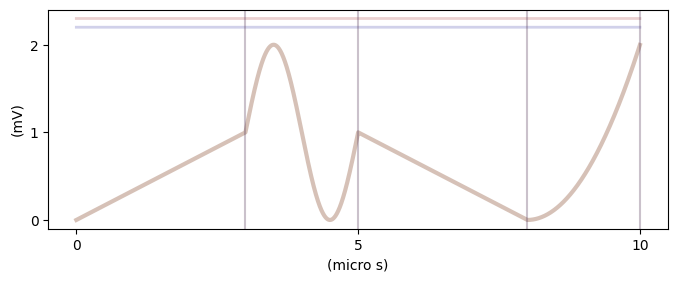

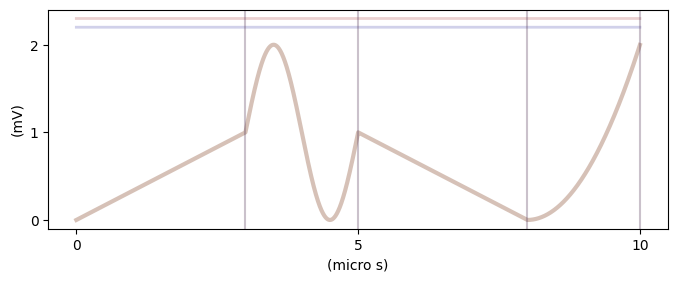

In [3]:
# For easy overview, we may plot the blueprint
plotter(bp1)

# The two bleak lines (red, blue) above the graph represent the channel markers.
# They are described below.

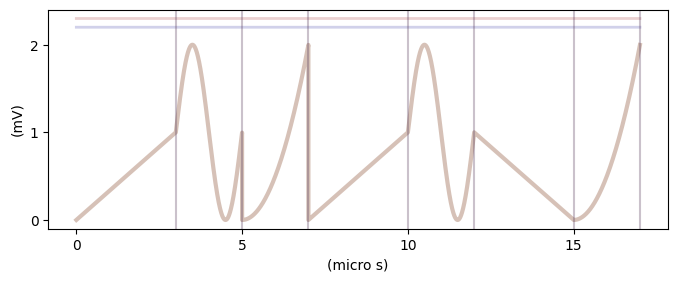

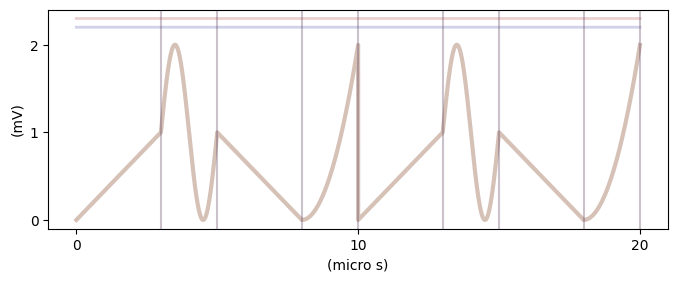

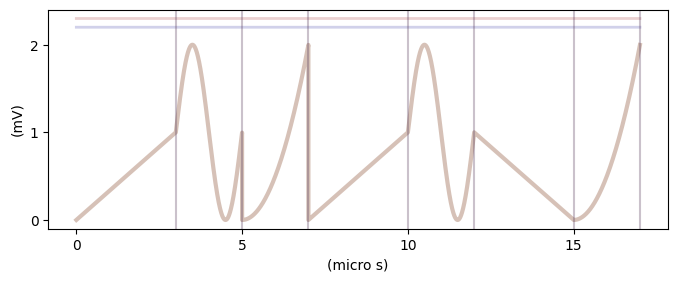

In [4]:
# Blueprints may be added together
bp2 = bp1 + bp1
plotter(bp2)

# Segments may be removed from a blueprint. They are removed by name.
bp2.removeSegment("ramp2")
plotter(bp2)

In [5]:
# A blueprint has a handful of different lengths one may check
print(f"Number of points in blueprint: {bp1.points}")
print(f"Length of blueprint in seconds: {bp1.duration}")
print(f"Number of segments in blueprint: {bp1.length_segments}")

Number of points in blueprint: 10000
Length of blueprint in seconds: 9.999999999999999e-06
Number of segments in blueprint: 4


## Markers
([back to ToC](#Table-of-Contents))

All markers are OFF by default. Markers can be added to a blueprint (switched ON) in two different ways. Either a marker is specified by its ON time in *absolute time* or by its ON time *relative* to a certain segment.

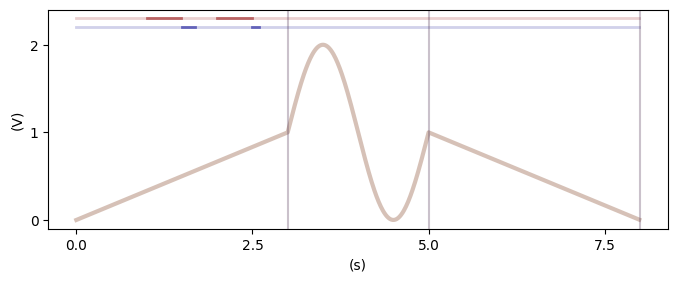

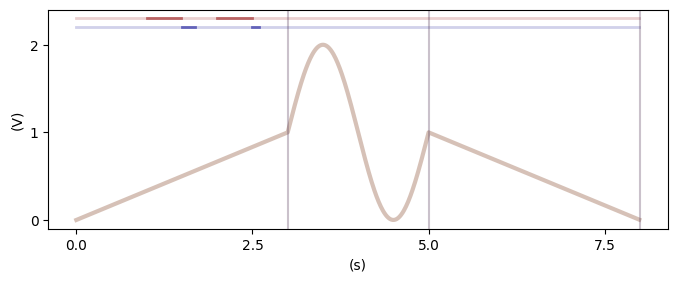

In [6]:
# Absolute time marker specification

# The blueprint has a list of tuples for each marker. The tuples are (switch_on_time, duration)

# create a blueprint
bp_atm = bb.BluePrint()
bp_atm.setSR(100)
bp_atm.insertSegment(0, ramp, (0, 1), dur=3)
bp_atm.insertSegment(1, sine, (0.5, 1, 1, 0), dur=2)
bp_atm.insertSegment(2, ramp, (1, 0), dur=3)

# specify markers in absolute time
bp_atm.marker1 = [(1, 0.5), (2, 0.5)]
bp_atm.marker2 = [(1.5, 0.2), (2.5, 0.1)]

plotter(bp_atm)

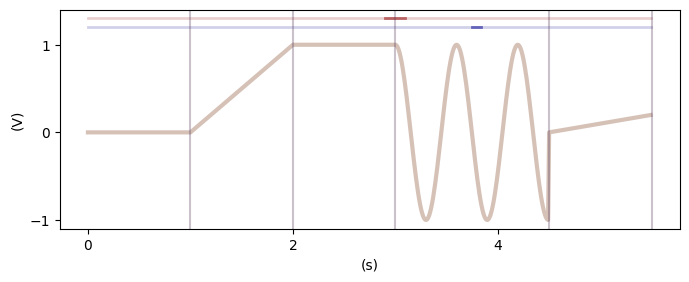

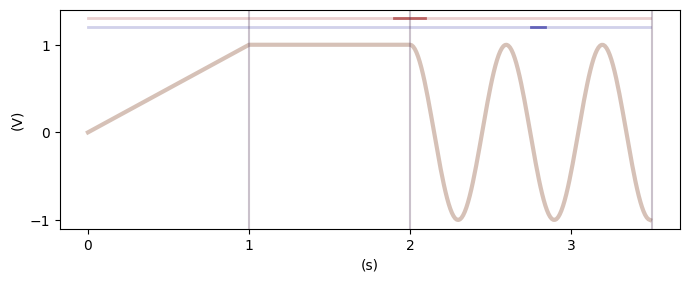

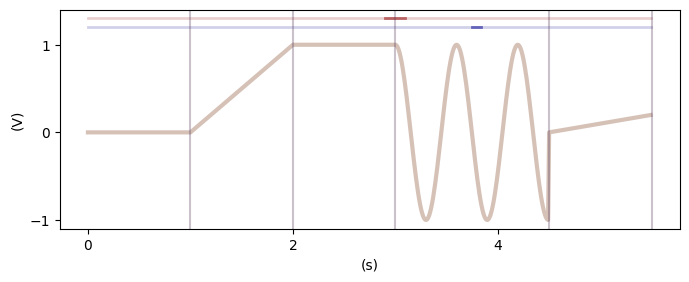

In [7]:
# Relative time marker specification

bp_rtm = bb.BluePrint()
bp_rtm.setSR(100)
bp_rtm.insertSegment(0, ramp, (0, 1), dur=1)
bp_rtm.insertSegment(1, ramp, (1, 1), dur=1)
bp_rtm.insertSegment(
    2, sine, (1.675, 1, 0, np.pi / 2), dur=1.5, name="mysine"
)  # This is the important segment
# make marker 1 go ON a bit before the sine comes on
bp_rtm.setSegmentMarker(
    "mysine", (-0.1, 0.2), 1
)  # segment name, (delay, duration), markerID
# make marker 2 go ON halfway through the sine
bp_rtm.setSegmentMarker("mysine", (0.75, 0.1), 2)

plotter(bp_rtm)

# Even if we insert segments before and after the sine, the markers "stick" to the sine segment
bp_rtm.insertSegment(0, ramp, (0, 0), dur=1)
bp_rtm.insertSegment(-1, ramp, (0, 0.2), dur=1)

plotter(bp_rtm)


# NB: the two different ways of inputting markers will never directly conflict, since one only specifies when to turn
# markers ON. It is up to the user to ensure that markers switch off again as expected, i.e. that different marker
# specifications do not overlap.

## Modifying blueprints
([back to ToC](#Table-of-Contents))

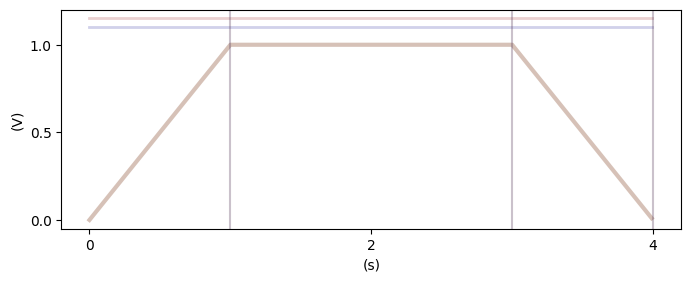

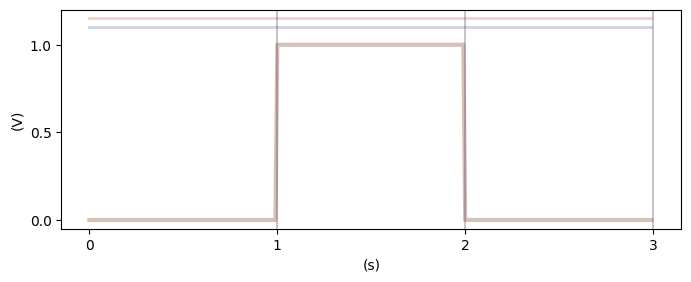

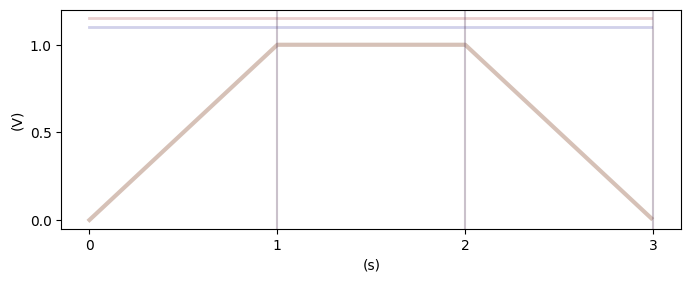

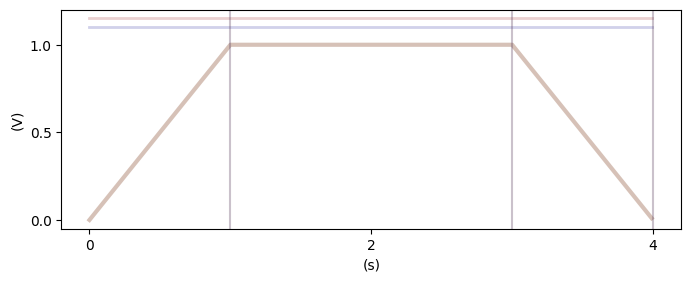

In [8]:
# An essential feature of blueprints is that they can be modified

bp_mod = bb.BluePrint()
bp_mod.setSR(100)

bp_mod.insertSegment(0, ramp, (0, 0), name="before", dur=1)
bp_mod.insertSegment(1, ramp, (1, 1), name="plateau", dur=1)
bp_mod.insertSegment(2, ramp, (0, 0), name="after", dur=1)

plotter(bp_mod)

# Functional arguments can be changed

# They are looked up by segment name
bp_mod.changeArg(
    "before", "stop", 1
)  # the argument to change may either be the argument name or its position
bp_mod.changeArg("after", 0, 1)

plotter(bp_mod)

# Durations can also be changed
bp_mod.changeDuration("plateau", 2)

plotter(bp_mod)

## Special segments
([back to ToC](#Table-of-Contents))

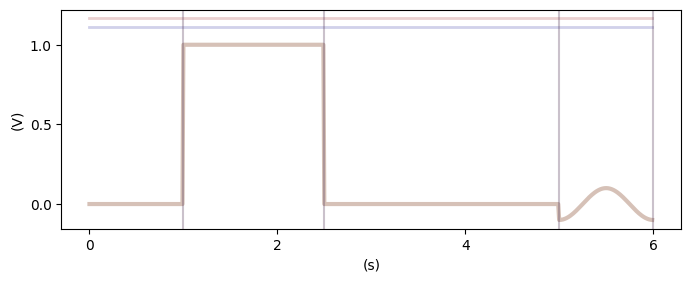

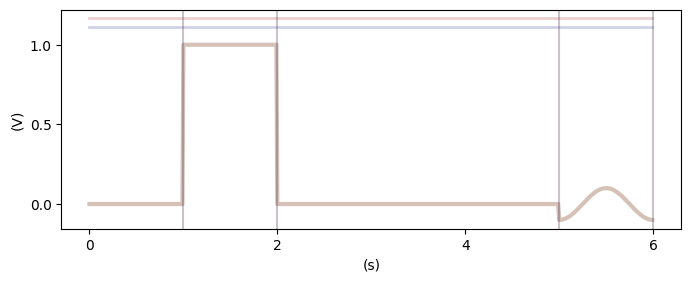

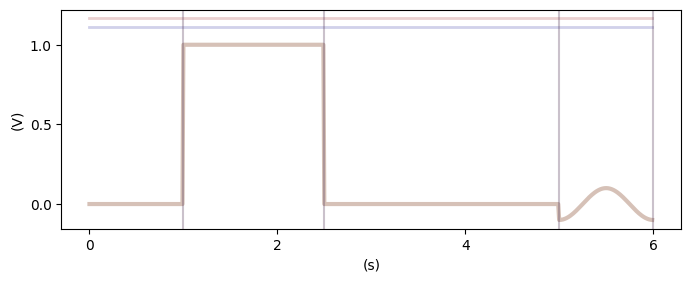

In [9]:
# The 'waituntil' segment fills up a part of the blueprint with zeros

# Example: a square pulse, then waiting until 5 s exactly and then a new sine

bp_wait = bb.BluePrint()
bp_wait.setSR(100)

bp_wait.insertSegment(0, ramp, (0, 0), dur=1)
bp_wait.insertSegment(1, ramp, (1, 1), name="plateau", dur=1)
# function must be sthe string 'waituntil', the argument is the ABSOLUTE time to wait until
bp_wait.insertSegment(2, "waituntil", (5,))
bp_wait.insertSegment(3, sine, (1, 0.1, 0, -np.pi / 2), dur=1)
plotter(bp_wait)

# If we make the square pulse longer, the sine still occurs at 5 s
bp_wait.changeDuration("plateau", 1.5)
plotter(bp_wait)

# Elements
([back to ToC](#Table-of-Contents))

Elements are containers containing blueprints. A valid element consists of blueprints that all have the same number of points and the same overall duration.

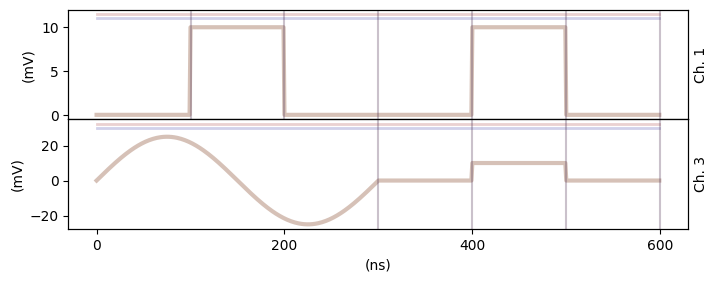

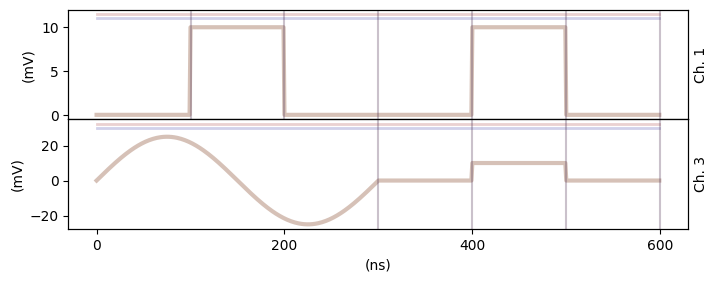

In [10]:
# Example 1

# Create the blueprints
bp_square = bb.BluePrint()
bp_square.setSR(1e9)
bp_square.insertSegment(0, ramp, (0, 0), dur=0.1e-6)
bp_square.insertSegment(1, ramp, (10e-3, 10e-3), name="top", dur=0.1e-6)
bp_square.insertSegment(2, ramp, (0, 0), dur=0.1e-6)
bp_boxes = bp_square + bp_square
#
bp_sine = bb.BluePrint()
bp_sine.setSR(1e9)
bp_sine.insertSegment(0, sine, (3.333e6, 25e-3, 0, 0), dur=0.3e-6)
bp_sineandboxes = bp_sine + bp_square

# Now we create an element and add the blueprints to channel 1 and 3, respectively
elem1 = bb.Element()
elem1.addBluePrint(1, bp_boxes)
elem1.addBluePrint(3, bp_sineandboxes)

# We can check the validity of the element
elem1.validateDurations()  # raises an ElementDurationError if something is wrong. If all is OK, does nothing.

# And we can plot the element
plotter(elem1)

In [11]:
# An element has several features
print(f"Designated channels: {elem1.channels}")
print(f"Total duration: {elem1.duration} s")
print(f"Sample rate: {elem1.SR} (Sa/S)")

Designated channels: [1, 3]
Total duration: 6e-07 s
Sample rate: 1000000000.0 (Sa/S)


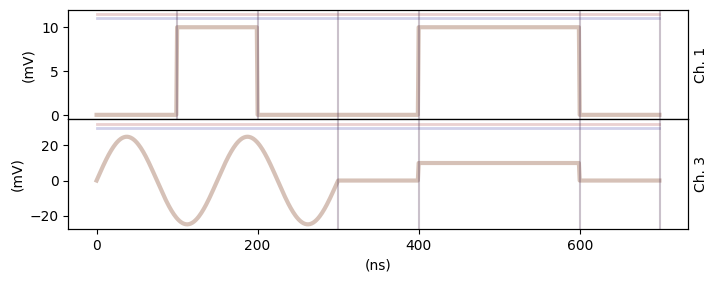

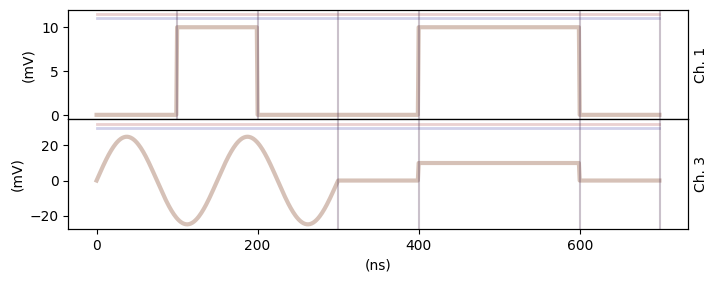

In [12]:
# We can modify the blueprints of an element through the element object

# Change the sine freq
elem1.changeArg(
    3, "sine", "freq", 6.67e6
)  # Call signature: channel, segment name, argument, new_value

# make the second plateaus last longer
elem1.changeDuration(
    1, "top2", 0.2e-6
)  # In this blueprint, the second top is called top2
elem1.changeDuration(3, "top", 0.2e-6)

plotter(elem1)

# Sequences
([back to ToC](#Table-of-Contents))

Finally, we have reached the top level of the module: sequences. Unsurprisingly, sequences are containers containing elements. All elements in a sequence must specify the same channels.

In [13]:
seq1 = bb.Sequence()

# We fill up the sequence by adding elements at different sequence positions.
# A valid sequence is filled from 1 to N with NO HOLES, i.e. if position 4 is filled, so must be position 1, 2, and 3

#
# Make blueprints, make elements

# Create the blueprints
bp_square = bb.BluePrint()
bp_square.setSR(1e9)
bp_square.insertSegment(0, ramp, (0, 0), dur=100e-9)
bp_square.insertSegment(1, ramp, (1e-3, 1e-3), name="top", dur=100e-9)
bp_square.insertSegment(2, ramp, (0, 0), dur=100e-9)
bp_boxes = bp_square + bp_square
#
bp_sine = bb.BluePrint()
bp_sine.setSR(1e9)
bp_sine.insertSegment(0, sine, (3.333e6, 1.5e-3, 0, 0), dur=300e-9)
bp_sineandboxes = bp_sine + bp_square

# create elements
elem1 = bb.Element()
elem1.addBluePrint(1, bp_boxes)
elem1.addBluePrint(3, bp_sineandboxes)
#
elem2 = bb.Element()
elem2.addBluePrint(3, bp_boxes)
elem2.addBluePrint(1, bp_sineandboxes)

# Fill up the sequence
seq1.addElement(1, elem1)  # Call signature: seq. pos., element
seq1.addElement(2, elem2)
seq1.addElement(3, elem1)

# set its sample rate
seq1.setSR(elem1.SR)

In [14]:
help(seq1.element(1).changeArg)

Help on method changeArg in module broadbean.element:

changeArg(channel: 'str | int', name: 'str', arg: 'str | int', value: 'int | float', replaceeverywhere: 'bool' = False) -> 'None' method of broadbean.element.Element instance
    Change the argument of a function of the blueprint on the specified
    channel.

    Args:
        channel: The channel where the blueprint sits.
        name: The name of the segment in which to change an argument
        arg: Either the position (int) or name (str) of
            the argument to change
        value: The new value of the argument
        replaceeverywhere: If True, the same argument is overwritten
            in ALL segments where the name matches. E.g. 'gaussian1' will
            match 'gaussian', 'gaussian2', etc. If False, only the segment
            with exact name match gets a replacement.

    Raises:
        ValueError: If the specified channel has no blueprint.
        ValueError: If the argument can not be matched (either the

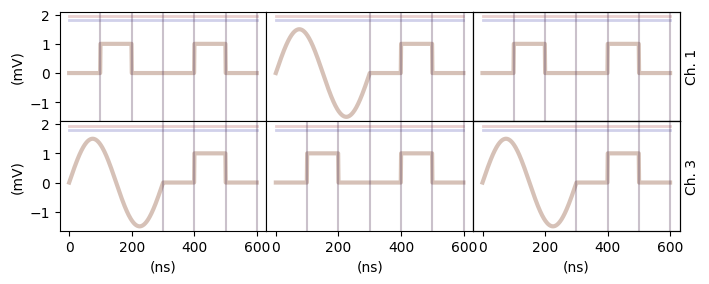

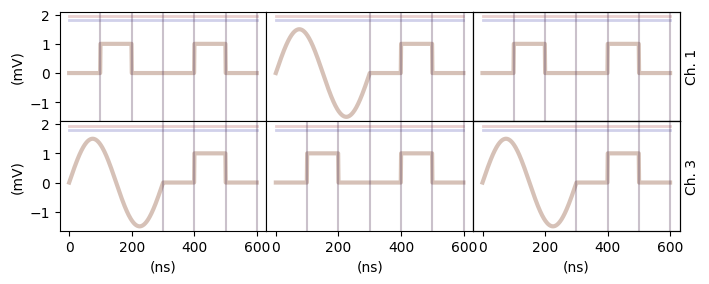

In [15]:
# The sequence can be validated
seq1.checkConsistency()  # returns True if all is well, raises errors if not

# And the sequence can (if valid) be plotted
plotter(seq1)

## Tektronix AWG 5014 output
([back to ToC](#Table-of-Contents))

The sequence object can output a tuple matching the call signature of the QCoDeS Tektronix AWG 5014 driver.

For the translation from voltage to AWG unsigned integer format to be correct, the voltage ranges and offsets of the AWG channels must be specified (NB: This will **NOT** work if the channels on the AWG are in high/low mode).

Furthermore, the AWG sequencer options should be specified for each sequence element.

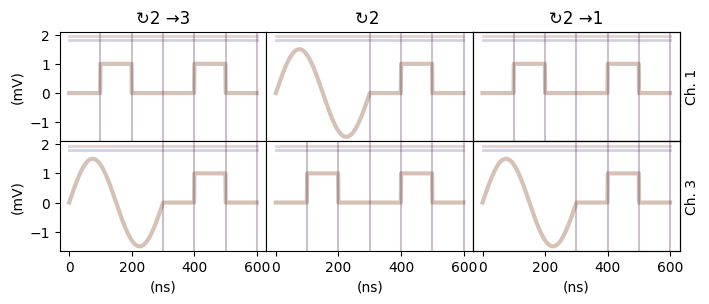

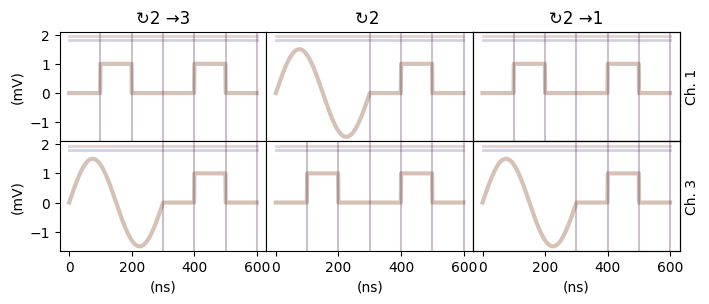

In [16]:
seq1.setChannelAmplitude(1, 10e-3)  # Call signature: channel, amplitude (peak-to-peak)
seq1.setChannelOffset(1, 0)
seq1.setChannelAmplitude(3, 10e-3)
seq1.setChannelOffset(3, 0)

# Here we repeat each element twice and then proceed to the next, wrapping over at the end
seq1.setSequencingTriggerWait(1, 0)
seq1.setSequencingNumberOfRepetitions(1, 2)
seq1.setSequencingEventJumpTarget(1, 0)
seq1.setSequencingGoto(1, 2)
#
seq1.setSequencingTriggerWait(2, 0)
seq1.setSequencingNumberOfRepetitions(2, 2)
seq1.setSequencingEventJumpTarget(2, 0)
seq1.setSequencingGoto(1, 3)
#
seq1.setSequencingTriggerWait(3, 0)
seq1.setSequencingNumberOfRepetitions(3, 2)
seq1.setSequencingEventJumpTarget(3, 0)
seq1.setSequencingGoto(3, 1)

# then we may finally get the "package" to give the QCoDeS driver for upload
package = seq1.outputForAWGFile()

# Note that the sequencing information is included in the plot in a way mimicking the
# way the display of the Tektronix AWG 5014
plotter(seq1)

In [17]:
# The package is a SLICEABLE object
# By slicing and indexing it, one may retrieve different parts of the sequence

chan1_awg_input = package[0]  # returns a tuple yielding an awg file with channel 1
chan3_awg_input = package[1]  # returns a tuple yielding an awg file with channel 3

both_chans_awg_input = package[
    :
]  # returns a tuple yielding an awg file with both channels

# This may be useful to make one big sequence for one experiment and then uploading part of it to one awg
# and part of it to another (since physical awg's usually don't have enough channels for a big experiment)

# To see how the channels are counted, look up the channels
package.channels

[1, 3]

In [18]:
## Example of uploading the sequence (requires having qcodes installed, see https://github.com/QCoDeS/Qcodes)

# from qcodes.instrument_drivers.tektronix.AWG5014 import Tektronix_AWG5014
# awg = Tektronix_AWG5014('AWG1', 'TCPIP0::172.20.3.57::inst0::INSTR', timeout=40)
# awg.make_send_and_load_awg_file(*package[:])

### Delays and filter compensation
([back to ToC](#Table-of-Contents))

In a real experimental setting, the signal transmission line may distort and/or delay the pulse sequence. The Sequence object can perform some compensation for this when making the `.awg` file.

In [19]:
# To delay channel 1 with respect to the other channels, set its delay
seq1.setChannelDelay(1, 0)
seq1.setChannelDelay(3, 123e-9)

# To apply for a high pass filter with a cut-off frequency of 1 MHz on channel 3, we can do
seq1.setChannelFilterCompensation(3, "HP", order=1, f_cut=1e6)
# or, equivalently,
seq1.setChannelFilterCompensation(3, "HP", order=1, tau=1e-6)

# Note that setting the filter compensation may invalidate the sequence in the sense that the specified voltage ranges
# on the AWG may have become too small. The function outputForAWGFile will warn you if this is the case.

newpackage = seq1.outputForAWGFile()

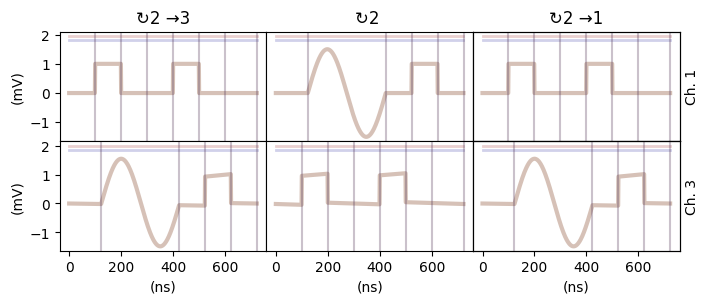

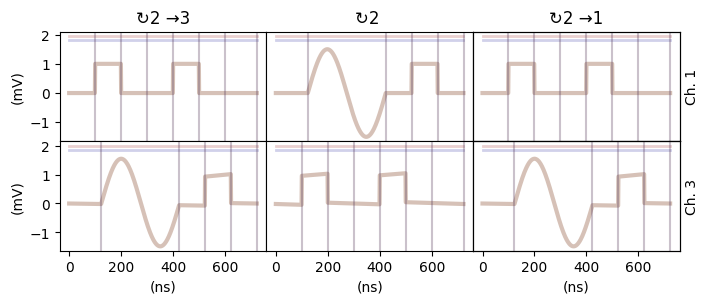

In [20]:
# For sanity checking, it may be helpful to see how the compensated waveforms look.
# The plotter function can display the delays and filter compensations

plotter(seq1, apply_filters=True, apply_delays=True)

## Sequences varying parameters
([back to ToC](#Table-of-Contents))

The module contains a few wrapper functions to easily generate sequences with some parameter(s) varying throughout the sequence. First two examples where a Base element is provided and varied, then an example where an existing Sequence is repeated.

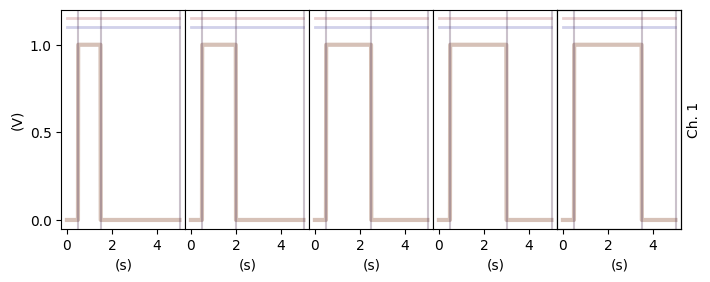

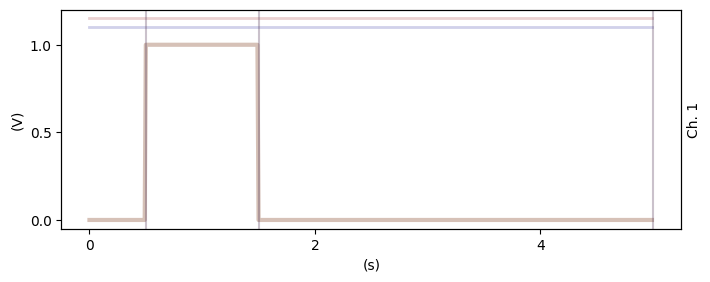

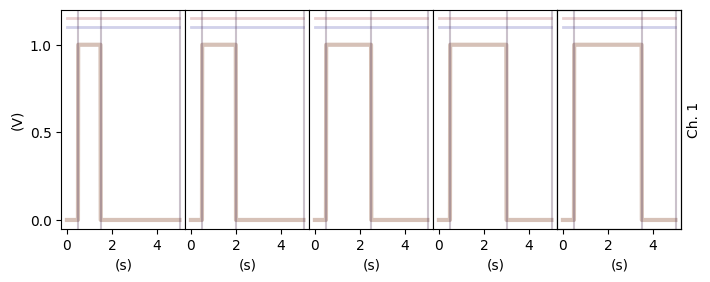

In [21]:
# Example 1: vary the duration of a square pulse

# First, we make a basic element, in this example containing just a single blueprint
basebp = bb.BluePrint()
basebp.insertSegment(0, ramp, (0, 0), dur=0.5)
basebp.insertSegment(1, ramp, (1, 1), dur=1, name="varyme")
basebp.insertSegment(2, "waituntil", 5)
basebp.setSR(100)

baseelem = bb.Element()
baseelem.addBluePrint(1, basebp)

plotter(baseelem)

# Now we make a 5-step sequence varying the duration of the high level
# The inputs are lists, since several things can be varied (see Example 2)
channels = [1]
names = ["varyme"]
args = ["duration"]
iters = [[1, 1.5, 2, 2.5, 3]]

seq1 = bb.makeVaryingSequence(baseelem, channels, names, args, iters)
plotter(seq1)

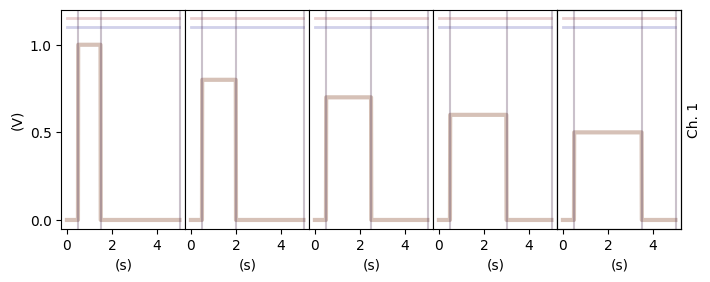

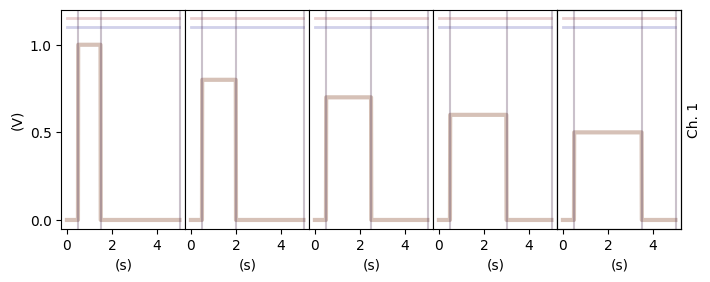

In [22]:
# Example 2: Vary the duration AND the high level

# It is straighforward to vary several things throughout the sequence

# We make the same base element as in Example 1
basebp = bb.BluePrint()
basebp.insertSegment(0, ramp, (0, 0), dur=0.5)
basebp.insertSegment(1, ramp, (1, 1), dur=1, name="varyme")
basebp.insertSegment(2, "waituntil", 5)
basebp.setSR(100)

baseelem = bb.Element()
baseelem.addBluePrint(1, basebp)

# Now we make a 5-step sequence varying the duration AND the high level
# We thus vary 3 things, a duration, a ramp start, and a ramp stop
channels = [1, 1, 1]
names = ["varyme", "varyme", "varyme"]
args = ["duration", "start", "stop"]
iters = [[1, 1.5, 2, 2.5, 3], [1, 0.8, 0.7, 0.6, 0.5], [1, 0.8, 0.7, 0.6, 0.5]]

seq2 = bb.makeVaryingSequence(baseelem, channels, names, args, iters)
plotter(seq2)

C:\Users\bethomse\dev\broadbean\src\broadbean\sequence.py:190: UserWarning: Deprecation warning. This function is only compatible with AWG5014 output and will be removed. Please use the specific setSequencingXXX methods.
  warnings.warn(


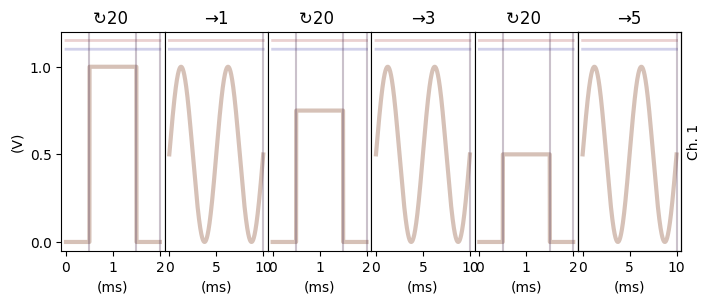

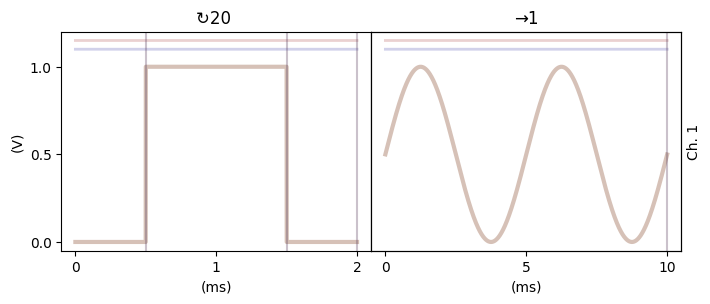

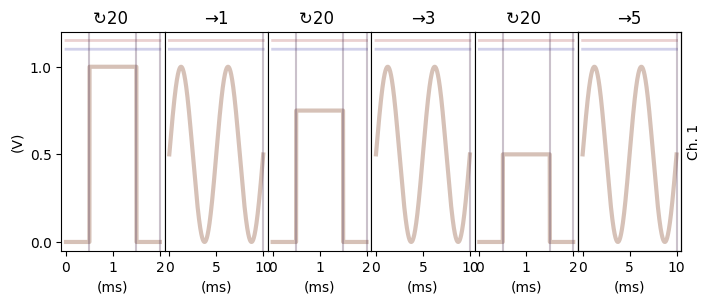

In [23]:
# Example 3: Modify the high level of a square pulse inside a sequence

#

pulsebp = bb.BluePrint()
pulsebp.insertSegment(0, ramp, (0, 0), dur=5e-4)
pulsebp.insertSegment(1, ramp, (1, 1), dur=1e-3, name="varyme")
pulsebp.insertSegment(2, "waituntil", 2e-3)
pulsebp.setSR(1e6)

sinebp = bb.BluePrint()
sinebp.insertSegment(0, sine, (0.2e3, 0.5, 0.5, 0), dur=10e-3)
sinebp.setSR(1e6)

elem1 = bb.Element()
elem1.addBluePrint(1, pulsebp)

elem2 = bb.Element()
elem2.addBluePrint(1, sinebp)

baseseq = bb.Sequence()
baseseq.setSR(1e6)
baseseq.addElement(1, elem1)
baseseq.addElement(2, elem2)

baseseq.setSequenceSettings(1, 0, 20, 0, 0)
baseseq.setSequenceSettings(2, 0, 1, 0, 1)

plotter(baseseq)

# now vary this sequence

poss = [1, 1]
channels = [1, 1]
names = ["varyme", "varyme"]
args = ["start", "stop"]
iters = [[1, 0.75, 0.5], [1, 0.75, 0.5]]

newseq = bb.repeatAndVarySequence(baseseq, poss, channels, names, args, iters)
plotter(newseq)